# Introduction to Supervised Machine Learning

Supervised machine learning generally accomplishes one of two kinds of tasks.



* Classification.  Once fully trained, the learning algorithm can identify categories of things.

For images, this could be faces versus not faces, or what kind of animal, or what letter was handwritten.  For audio, it could classify the word that was spoken.  For emails, it could decide what is spam.
 


* Regression.  Regression attempts to fit a function (typically with numerical output) to some data.  Prediction of prices of apartments given their attributes, or predicting who has the advantage in a game given the pieces - these are regression problems.



Both of these fall under supervised machine learning because of the way the learning works:  the learner has many "labeled examples" that are inputs labeled with the correct output.  The learner has "the answers" for all the training data, and it just needs to find a function that interpolates and extrapolates reasonably from there.


Depending on the learning algorithm and how much data there is to process, *training*, or building the function that classifies or interpolates, could take a long time.  But here we're going to present an algorithm that takes basically no time to train:  k-nearest neighbors.


# Sample problem:  digits

Our dataset that we will try to learn from will be a relatively simple one:  the digits library of scikit-learn.  It's grayscale instead of color, and relatively low resolution, and there's nothing in the image besides the digit to cause confusion, so this would be considered a relatively easy dataset to learn from.

The data consists of 8x8=64 brightness values, labeled with the correct digit.  The task is classification:  presented with a new digit, a trained learner should be able to produce a correct classification.

In [26]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
digits = load_digits()
print(digits.data.shape) # Examples x 64 pixels

(1797, 64)


<Figure size 432x288 with 0 Axes>

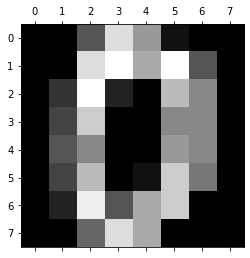

In [27]:
import matplotlib.pyplot as plt 
plt.gray() 
plt.matshow(digits.images[0]) # Notice images[0] is 2D

# k-nearest neighbors

The k-nearest neighbors strategy is most easily pictured in two dimensions, even though we're dealing with 64 dimensions here.  Images representing the same digit should tend to cluster near each other with similar values.



To find the correct classification of a point, we consult its neighbors - the *k* (let's say 3) closest examples that it does have a label for.  If they all agree on their own classification, then this is a very good guess for the new point.  But if they disagree, then the must vote, and majority rule determines the label.


(What does closest mean?  We typically use Euclidean distance between the data vectors. Letting $\Delta x_i$ be a difference in a particular vector element $i$, such as the difference at one pixel, the distance is $\sqrt{\Delta x_1^2 + \Delta x_2^2 + \ldots + \Delta x_n^2}$.) 

Most learning algorithms in scikit-learn spend a while adapting to the data, but k-nearest neighbors requires very little setup.  As a speed adaptation, the algorithm may create some additional structures that make lookup of the three closest fast (using hash tables in creative ways).  But that's about it - from beginning to end, the prediction for a point is the majority vote of the k closest neighbors.



Let's see how to train on all the digits data available for scikit-learn.

In [28]:
from sklearn.neighbors import KNeighborsClassifier
# "Fit" is the name of all training methods in scikit-learn;
# neighbors doesn't fit so much as store for efficient retrieval
nbrs = KNeighborsClassifier(n_neighbors=3).fit(digits.data, digits.target)

nbrs.score(digits.data, digits.target) # Find accuracy on the training dataset

0.993322203672788

# The train/test split and overfitting

The previous results of 99% accuracy were a little too good to be true.  We used k-nearest neighbors where one "neighbor" was always the original, labeled point itself.  (Reducing k to 1 thus would do what?) It seems like cheating to be given the answers ahead of time in this way.


In general, most classifiers have this issue - you shouldn't evaluate solely on your training data, or the results won't give a sense of how well you do on genuinely new data points.  In fact, many algorithms run the risk of getting too cozy with the training data and *overfitting* to its idiosyncracies, learning rules that only happen to be true of the training data in particular. You can't tell whether that has happened if you just evaluate on the training data.



So, at the very least, you must *split the data into training and testing data*.  It's best to do this blindly and randomly, because the distributions of training and testing data should match.


You're allowed to use a much larger portion of training data for training - somewhere between 5% and 20% of your data should be reserved for testing.

Scikit-learn's train_test_split() function performs exactly this task of separating out randomly selected examples for testing.

In [29]:
from sklearn.model_selection import train_test_split
data_train, data_test, label_train, label_test = train_test_split(digits.data, digits.target, test_size=0.2)
nbrs = KNeighborsClassifier(n_neighbors=3).fit(data_train, label_train)

nbrs.score(data_test,label_test)

0.9861111111111112

It turns out, on this dataset, K-nearest neighbors will still do great - still roughly 99% accuracy when the training data is separated from the test data.

In [30]:
nbrs.predict(data_test[0:3])

array([6, 2, 5])

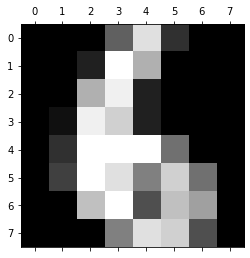

In [31]:
def reshape_and_show(num, data_test):
    image = data_test[num].reshape(8,8)
    plt.matshow(image)

reshape_and_show(0,data_test)

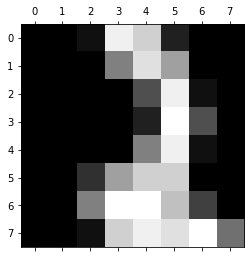

In [32]:
reshape_and_show(1,data_test)

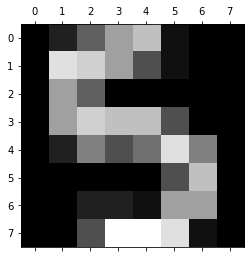

In [33]:
reshape_and_show(2,data_test)

But there must be something k-nearest neighbors is bad at, or people wouldn't get so excited about neural networks.  Let's try a harder dataset -- a faces dataset.

The LFW (Labeled Faces in the Wild) dataset is another in scikit-learn.  The faces are labeled with who they are.  We can ask for just the faces supported by at least 100 examples.

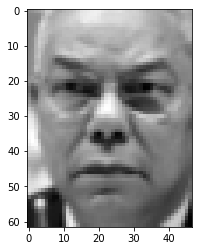

In [34]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person = 100)

plt.imshow(faces.images[5], cmap="gray")

In [35]:
data_train, data_test, label_train, label_test = train_test_split(faces.data, faces.target, test_size=0.2)
nbrs = KNeighborsClassifier(n_neighbors=3).fit(data_train, label_train)
 
nbrs.score(data_test,label_test)


0.5964912280701754

Better than chance, as there are 5 people in the data and chance would be 0.2, but clearly there's room for improvement.


# Validation data and strategies

Can we go back and change our choice of k?  You shouldn't, because once you've looked at the test data, any changes you make could start creating improvement that doesn't carry over to the real world.  Your choices from here on out could cause overfitting to the test data.

It's probably not as bad as overfitting to the training data, because the overfitting is indirect - you're changing parameters rather than telling the answers directly.  Still, expect a performance drop on moving to the "real world" if you went back and forth trying to get the best test score possible.


A way to avoid this problem is to split the training data yet again, splitting off a portion of the training data to be "validation data."  Now you can go back and forth trying to improve your performance without worrying that test set knowledge is leaking into your decisions.


A still more clever idea is to rotate which fraction of your training data is the validation set.  So you train on the first 80% then test on 20%, then train on the first 60% and last 20% while training on that missing 20%, and so on 5 times (for example).  Ideally, this is still separate from the test data, which is reserved for final testing.  This is called "cross-validation."

An extreme version in which just 1 example is left out every time is called "leave-one-out-cross-validation," or LOOCV for short.  This ideally gives a more accurate view of the algorithm under different circumstances, and is less dependent on which data is validation data.

Scikit-learn similarly has a function for cross-validation.

In [36]:
from sklearn.model_selection import cross_val_score

cross_val_score(nbrs, data_train, label_train)

array([0.63934426, 0.57377049, 0.57692308, 0.62637363, 0.5989011 ])

Some part of machine learning is just trying different parameters to see what works best - although as we'll discover, we don't expect k-nearest neighbors to work that well regardless of parameters.

In [37]:
import numpy as np

for i in range(1,10):
  nbrs = KNeighborsClassifier(n_neighbors=i)
  print(np.mean(cross_val_score(nbrs, data_train, label_train)))

0.589863688224344
0.5635861406353209
0.6030625112592326
0.6205788746772354
0.6260253407794392
0.6293100342280671
0.6370083468444124
0.6436077583618568
0.6359274605176244


# Back to k-NN

k-nearest neighbors can be adapted to other kinds of datasets besides numerical.  Boolean variables can be turned into 0 or 1.  Categorical variables (like strings) can be turned into "one-hot" encodings, where each possible category gets a boolean variable.

Numbers could be standardized by dividing by their maximum, or by their standard deviation; this keeps numbers' inherent scales from biasing the distance calculations.  (Converting a scale from miles to inches shouldn't make the feature seem suddenly more important, just because the numbers are bigger.)


But, kNN isn't that powerful for high-dimensional machine learning problems.  With many dimensions, random points aren't all that close or similar, so the reasoning for the method breaks down.  Datasets with very high kNN performance are the exception.


Still, k-nearest neighbors is a bona fide machine learning method, and can serve as a nice benchmark to see how well other methods are doing.

# Exercise

Try "training" a knn classifier on the Iris dataset (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html) and see your cross-validation performance with cross_val_score().

In [38]:
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

iris = load_iris()
nbrs = KNeighborsClassifier(n_neighbors=3)

cross_val_score(nbrs, iris.data, iris.target)

array([0.96666667, 0.96666667, 0.93333333, 0.96666667, 1.        ])